In [252]:
# SPFDM Assignment 1
# Luuk Oudshoorn and Willem-Jan de Voogd
# Fall 2020

In [253]:
import time
import numpy as np
import pandas as pd
import datetime as dt
from glob import glob
from scipy.interpolate import interp1d
%matplotlib inline
# Import some of the basis required functions
from scipy.stats import norm
from joblib import Parallel, delayed
import networkx as nx
from scipy.stats import norm
import scipy as sp
import matplotlib.pyplot as plt
import ffn 
from matplotlib import collections as matcoll

Text(0, 0.5, 'Rate (%)')

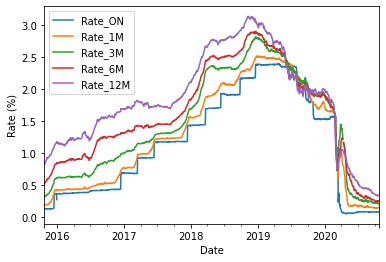

In [254]:
# Load LIBOR Rates
periods = ['ON','1M','3M','6M','12M']
LIBOR = pd.DataFrame()
for period in periods:
    filename = glob('./USD'+period+'*.csv')[0]
    LIBOR_sub = pd.read_csv(filename)
    LIBOR_sub['DATE'] = pd.to_datetime(LIBOR_sub['DATE'])
    LIBOR_sub.columns = ['Date','Rate_'+period]
    LIBOR_sub = LIBOR_sub.set_index('Date')
    LIBOR_sub = LIBOR_sub.replace('.',np.nan)
    LIBOR_sub['Rate_'+period] = LIBOR_sub['Rate_'+period].astype(float)
    LIBOR = pd.concat((LIBOR,LIBOR_sub),axis=1)
LIBOR.plot()
plt.ylabel('Rate (%)')

In [255]:
# Libor rates from ICE
# https://www.theice.com/marketdata/reports/170
#LIBOR = pd.DataFrame({'Name':['Rate_3M','Rate_6M','Rate_12M'],'Rate':[-0.52971,-0.52329,-0.47386]}).set_index('Name')
#LIBOR
# Latest libor rates
# These are annualized interest rates
LIBOR = pd.DataFrame({'Rate':LIBOR.iloc[-1,2:]})
LIBOR.loc['Rate_9M'] = interp1d([3,6,12],LIBOR.Rate,kind='linear')(9)

In [256]:
# OIS curve, is 0.1% lower than Libor curve assuming fixed spread
# We bootstrap the OIS for quarterly payments
OIS = (LIBOR -0.1).sort_index()
OIS

,Rate
Rate_12M,0.236630
Rate_3M,0.116500
Rate_6M,0.149380
Rate_9M,0.193005


In [257]:
# OIS is the first part of the zero curve
zerocurve = pd.DataFrame({'Years':[1,0.25,0.5,0.75],'Zero rate':OIS.values.flatten()})

zerocurve = zerocurve.set_index('Years').sort_index()
zerocurve
for i in np.arange(1.25,30.1,0.25):
    zerocurve.loc[i] = np.nan
zerocurve

,Zero rate
Years,
0.25,0.116500
0.50,0.149380
0.75,0.193005
1.00,0.236630
1.25,NaN
...,...
29.00,NaN
29.25,NaN
29.50,NaN


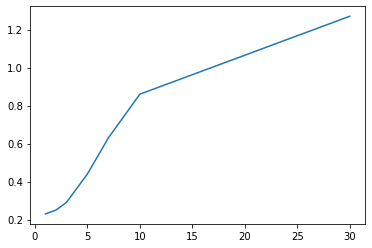

,Swap_Rate
Years,
1.00,0.230000
1.25,0.235000
1.50,0.240000
1.75,0.245000
2.00,0.250000
...,...
29.00,1.249500
29.25,1.254625
29.50,1.259750


In [258]:
# To obtain longer rates we need to bootstrap
# For bootstrapping we also need the swap rates. These are obtained from 
# http://www.interestrateswapstoday.com/swap-rates.html
def read_interp_swaprates():
    swaprates  =  pd.DataFrame({'Name':['1-Year','2-Year','3-Year','5-Year','7-Year','10-Year','30-Year'],'Rate':[0.230,0.25,0.29,0.44,0.63,0.86,1.270]}).set_index('Name')
    swaprates['NMonths'] = [12,24,36,60,84,120,360]
    #We need to interpolate swaprates to get all intermediate values
    to_interpolate = np.arange(12,361,3)
    # We use cubic interpolation as this generates a much smoother curve
    interpolated = interp1d(swaprates['NMonths'],swaprates['Rate'],kind='linear')(to_interpolate)
    swaprates_interp = pd.DataFrame({'Years':to_interpolate/12,'Swap_Rate':interpolated})
    return swaprates_interp.set_index('Years')
swaprates_interp = read_interp_swaprates()
plt.plot(swaprates_interp.index, swaprates_interp.Swap_Rate)
plt.show()
swaprates_interp

In [259]:
# Having both libor and swap rates we should be able to bootstrap the zero curve

In [260]:
def bootstrap(disc_rates, disc_rates_times,to_calculate, swaprate, duration, payterm):
    """Takes known discounting rates and known swap rate for some times
       and returns the swaprate for an unknown time"""
    # payterm = years between payments
    # discount rates = libor/ois like rates
    # swaprate is the at-par rate for the IRS
    # duration is the number of years of the swap
    
    Npayments = duration / payterm - 1 # because we estimate one
    # We loop through all payments except for the unknown
    swapvalue = 0
    for i,time in enumerate(disc_rates_times):
        if time != duration: # intermediate payouts
            payout = swaprate * payterm
        elif time ==duration: #final payout
            payout = swaprate * payterm + 100
        depreciation = np.exp(-time*disc_rates[i]/100)
        swapvalue += payout * depreciation
    # The swap is now worth par, thus 100. We calculate the rate solving the 
    # missing term
    
    if to_calculate == duration:
        # If we miss the last term, then divide by 100+coupon
        rate = np.log((100-swapvalue)/(swaprate * payterm + 100))/(-to_calculate)
    elif to_calculate != duration:
        # If we search for an intermediate term, divide by coupon
        rate = np.log((100-swapvalue)/(swaprate * payterm))/(-to_calculate)
    return (rate*100)

In [261]:
# Example from Hull
disc_rates = [4,4.5,4.8]
disc_rates_times = [0.5,1,1.5]
to_calculate = 2
swaprate   = 5
duration   = 2
payterm    = 0.5
bootstrap(disc_rates, disc_rates_times,to_calculate, swaprate, duration, payterm)

4.952932701412535

In [262]:
# Inverse problem of Hull; we know 0.5,1,2
disc_rates = [4,4.5,4.95293270]
disc_rates_times = [0.5,1,2]
to_calculate = 1.5
swaprate   = 5
duration   = 2
payterm    = 0.5
bootstrap(disc_rates, disc_rates_times,to_calculate, swaprate, duration, payterm)

4.800000075157118

In [263]:
# We have swap rates for all 3 month periods by interpolation
# Using each swap rate we can now equate the zero yield rate for that period
for years,row in zerocurve.iterrows():
    if (np.isnan(row['Zero rate'])):
        # Unknown rate, bootstrap!
        # Obtain swap rate for this maturity
        swaprate = swaprates_interp.loc[years].Swap_Rate
        known_rates = zerocurve.loc[:years-0.25]
        zerorate = bootstrap(known_rates.values,known_rates.index,years,
                             swaprate,years,0.25)
        zerocurve.loc[years] = zerorate


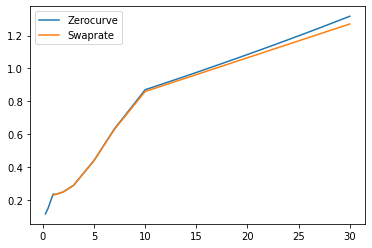

In [264]:
plt.plot(zerocurve.index, zerocurve.values,label='Zerocurve')
plt.plot(swaprates_interp.index, swaprates_interp.Swap_Rate,label='Swaprate')
plt.legend()

In [265]:
# Now that we have the zerocurve, we can use it to valuate all kinds of IRS!

In [266]:
LIBOR

,Rate
Rate_3M,0.216500
Rate_6M,0.249380
Rate_12M,0.336630
Rate_9M,0.293005


In [267]:
class swaps():
    def __init__(self,start, lifetime,dT=0.25,swaprate=None,lagged_libor=None):
        """Initialize function. For any swap we determine
           its value as difference between long and short
           position in bonds. If inception if now, we solve
           this value such that it is zero.
           For each swap we pay fixed and receive floating rate
           
           start = float number of years, e.g. -0.5
           lifetime = total lifetime since inception, e.g. 5
           swaprate = some rate in % if defined. To find swaprate, 
           it should be set to None
           lagged_libor = libor if swap already exists"""
        self.swapstart = start
        self.lifetime = lifetime
        self.swaprate=swaprate
        self.dT = dT
        if lagged_libor:
            self.floatlibor = lagged_libor
        else:
            self.floatlibor = 10.5
        if self.swaprate:
            # We need to calculate the present day value
            # of this swap, since it already exists and has
            # a defined swaprate
            self.irsvalue = self.valuate(self.swaprate,print_=True)
        else:
            # We need to find the swaprate such that the net
            # present value equals zero
            self.get_rate()
    
    def valuate(self,swaprate,print_=False,lagged_libor = 10.2):
        """We pay fixed and thus are short in fixed bond at 
           the swaprate r. We receive floating and are thus 
           long in floating bond."""
        # Fixed lag
        short = self.fixed_bond(swaprate)
        if print_:
            print('Fixed',short)
        # Floating lag
        long = self.floating_bond(self.floatlibor)
        if print_:
            print('Float',long)
        return short - long
        
    def fixed_bond(self,rate):
        time_remaining = self.lifetime + self.swapstart
        start     = [self.swapstart+w*self.dT for w in range(0,1000)]
        start     = np.sort(np.abs(start))[1]
        
        timesteps = np.arange(start,time_remaining,self.dT)
        
        # Each step in timesteps, we get discounted floating rate
        # Additionally, we receive final payment
        value = 0
        for timestep in timesteps:
            discount_rate = zerocurve.loc[timestep].iloc[0]
            discount_factor = np.exp(-timestep*discount_rate/100)
            discounted_cash = (rate*self.dT) * discount_factor
            value += discounted_cash
        # Final payment
        discount_rate = zerocurve.loc[time_remaining].iloc[0]
        discount_factor = np.exp(-time_remaining*discount_rate/100)
        value += (100+rate*self.dT)*discount_factor
        return value
    
    def floating_bond(self,libor):
        """Floating bond is worth par after the first next payment
           and pays the LIBOR rate"""
        time_remaining = self.lifetime + self.swapstart
        start     = [self.swapstart+w*self.dT for w in range(0,1000)]
        start     = np.sort(np.abs(start))[1]
        
        discount_rate = zerocurve.loc[start].iloc[0]
        discount_factor = np.exp(-start*discount_rate/100)
        value = (100+libor * self.dT) * discount_factor
        
        return value
    
    def valuate_call(self,x):
        return np.abs(self.valuate(x))
   
    def get_rate(self):
        """Find the rate r that makes the value of a swap equal 
           zero"""
        from scipy.optimize import minimize
        fit_res = minimize(self.valuate_call,x0=[1])
        self.fitrate = fit_res['x'][0]
        

In [268]:
# Paper example
zerocurve.loc[0.25] = 10
zerocurve.loc[0.5] = 10.5
zerocurve.loc[0.75] = 11
zerocurve.loc[1] = 11.5

# Find value of swap
swapper = swaps(0,1,0.25,8)#-0.25,1.5,0.5,8)   
swapper.irsvalue   

Fixed 96.60929802037867
Float 100.09117972190764


-3.4818817015289625

In [269]:
# Find rate for swap
swapper = swaps(0,1,0.25,None)
swapper.fitrate

11.727583687444431

In [270]:
# Example slides
zerocurve.loc[0.25] = 10
zerocurve.loc[0.75] = 10.5
zerocurve.loc[1.25] = 11

swapper = swaps(-0.25,1.5,0.5,8,10.2)#-0.25,1.5,0.5,8)   
swapper.irsvalue  

Fixed 98.23789590103716
Float 102.50507175417775


-4.267175853140586

<h2>Mean reversion</h2>

In [271]:
# We use mean reversion rather than geometric brownian motion

In [272]:
# Download S&P500 data for 60 months, since 12*feb < 60
# We choose the daily closing prices. The ticker symbol for 
# the S&P is ^GSPC on Yahoo Finance.
sp500_pdaily = ffn.get('^GSPC:Close', start='2015-09-01',end='2020-08-31',)

# Convert the daily prices to monthly prices by taking the closing 
# value of each month (e.g. last trading day)
sp500_pmonthly = sp500_pdaily.to_monthly()

# Check length
print('Number of months equals {}'.format(len(sp500_pmonthly)))
sp500_rmonthly = sp500_pmonthly.to_returns()

startingprice = sp500_pmonthly['gspcclose'].iloc[-1]
strikeprice = 3300
sigma = sp500_rmonthly.std().iloc[-1]

Number of months equals 60


/home/luuk/anaconda3/lib/python3.8/site-packages/ffn/core.py:1388: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  res = orig.ix[dts.values]


In [273]:
# We consider everything in logs. So define
# x_t = ln (S_t)
# So every step we have 
# x_t = ln(S_t-1)+ln(d)=D  and  x_t = ln(S_t-1)+ln(u) = U
# 

In [274]:
class BinomialTree():
    def __init__(self,N, T, S, sigma, K,ret_arrays=True, ret_option=False, call_put = 'call', risk_premium = 0):
        self.N = N
        self.T = T
        self.S = S
        self.x0 = np.log(S)
        self.sigma = np.sqrt(12)*0.0428156
        self.rf = np.log((1+0.005/4)**4)
        self.K = K
        self.ret_arrays = ret_arrays
        self.ret_option = ret_option
        self.call_put = call_put
        self.eta = 1/12 # half life time of mean reversion
        self.ltm = 3500 # long term mean
        self.xmean = np.log(self.ltm) - sigma**2/(2*self.eta)
        self.binomial_tree()
        
    def prob_p(self,xt):
        dt = self.T/self.N
        return (0.5+0.5 * (self.eta*(-(xt-self.xmean))*np.sqrt(dt))/
                    (np.sqrt(self.eta**2 * (xt-self.xmean)**2 * dt + self.sigma**2)))

    def binomial_tree(self):
        """Uses mean reversion method"""
        
        # Time steps given total duration and number of steps
        dt = self.T/self.N
        # Fill the tree
        log_pricetree = np.zeros([self.N+1,self.N+1])

        # Consider i up moves and j down moves
        for i in range(self.N+1):
            for j in range(self.N+1):
                if i+j <= self.N: 
                    x_ij = (self.xmean * (1-np.exp(-self.eta*(i+j)*dt)) + 
                            self.x0*np.exp(-self.eta*(i+j)*dt) +
                            (i-j)*self.sigma * np.sqrt(dt))
                    log_pricetree[j,i+j] = x_ij

        price_tree = np.exp(log_pricetree)
        self.price_tree = price_tree
        self.log_pricetree = log_pricetree

        self.probup = np.zeros([self.N+1,self.N+1])
        for i in range(self.N+1):
            for j in range(self.N+1):
                if i+j <= self.N: 
                    self.probup[j,i+j] = self.prob_p(log_pricetree[j,i+j])



        # Derive the option value
        option = np.zeros([self.N+1, self.N+1])

        if self.call_put == 'call':
            option[:,self.N] = np.max(np.vstack((np.zeros(self.N+1),price_tree[:,self.N]-self.K)),axis=0)
        elif self.call_put == 'put':
            option[:,self.N] = np.max(np.vstack((np.zeros(self.N+1),self.K-price_tree[:,self.N])),axis=0)

        # Consider i up moves and j down moves
        for i in np.arange(self.N-1,-1,-1):
            for j in np.arange(self.N-1,-1,-1):
                if i+j < self.N: 
                    p_up = self.prob_p(log_pricetree[j,i+j])
                    discount = np.exp(-dt*self.rf)
                    #print(i,j,option[j,i+j+1],option[j+1,i+j+1],p_up)
                    option[j,i+j] = discount*(p_up*option[j,i+j+1] + (1-p_up)*option[j+1,i+j+1])

        self.price_tree = price_tree
        self.option_tree = option
        self.option_value = option[0,0]

        if self.ret_arrays:
            return price_tree, option          
        if self.ret_option:
            return option[0,0]

    def plot_graph(self,data, filename=''):
        n = self.N
        fig, ax=plt.subplots(figsize=(7,5))
        G=nx.Graph()
        for i in range(0,n+1):
            for j in range(1,i+2):
                if i<n:
                    G.add_edge((i,j),(i+1,j))
                    G.add_edge((i,j),(i+1,j+1))

        posG={}

        for node in G.nodes:
            posG[node]=(node[0],n+2+node[0]-2*node[1])
        nx.draw(G,pos=posG, with_labels=False, ax=ax)

        dict_ = {}
        for node in G.nodes:
            dict_[node] = 0*' '+np.round(data[node[1]-1,node[0]],3).astype(str)
        labels=nx.draw_networkx_labels(G,pos=posG,labels=dict_, ax=ax,verticalalignment='bottom',
                                       horizontalalignment='right',bbox=dict(facecolor='w',alpha=.6))
        dict_ = {}
        for edge in G.edges:
            dict_[edge] = 'u' if edge[1][1]<=edge[0][1] else 'd'

        labels=nx.draw_networkx_edge_labels(G,pos=posG,edge_labels=dict_, ax=ax)


        plt.xlim(-0.4-(n+3)/10,n+0.2)
        plt.ylim(-0.4,6.4*n/3)
        plt.tight_layout()
        if filename is not '':
            plt.savefig(filename,dpi=500,bbox_inches='tight')
        return     

<>:109: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:109: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-274-342b73add117>:109: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if filename is not '':


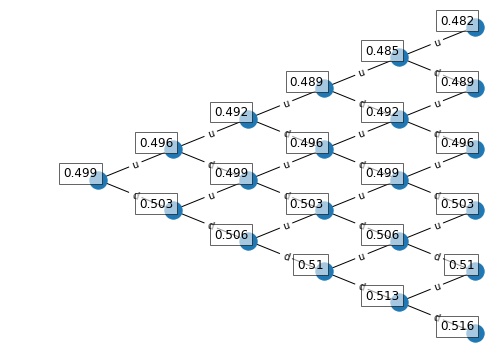

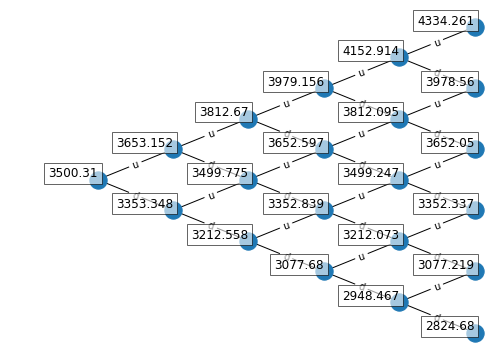

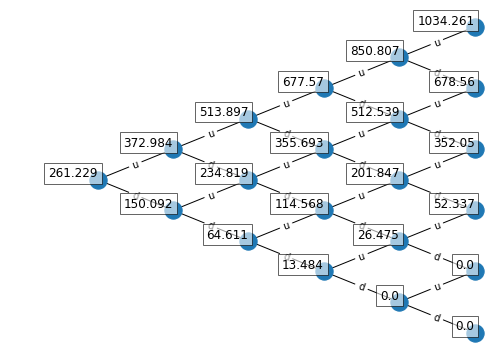

In [275]:
FirstBinomialTree = BinomialTree(5,5/12,startingprice,sigma,3300,call_put='call')
FirstBinomialTree.plot_graph(FirstBinomialTree.probup)
FirstBinomialTree.plot_graph(FirstBinomialTree.price_tree)
FirstBinomialTree.plot_graph(FirstBinomialTree.option_tree)

In [300]:
# Exercise 1: Monte Carlo Simulation
class MonteCarlo():
    def __init__(self,sigma = None, K = 3300):
        # If we do not call the function with a value, 
        # initialize at the "standard" numbers
        self.rf = np.log((1+0.005/4)**4)
        self.sigma = np.sqrt(12)*0.0428156
        self.K     = K
        np.random.seed(42)
        self.x0 = np.log(startprice)
        self.eta = 1/12 # half life time of mean reversion
        self.ltm = 3500 # long term mean
        self.xmean = np.log(self.ltm) - self.sigma**2/(2*self.eta)

    def simulate(self,N,T):
        # We generate N(0,1) random variables
        # and multiply by sigma to get N(0,vola^2) variables
        k=1
        phis = np.random.randn(N)
        sigma = self.sigma**2 / 2*k * (1-np.exp(-2*k*T))
        mu = self.x0  *np.exp(-k*T) + self.xmean * (1-np.exp(-k*T))
        logprices = phis * sigma + mu
        prices = np.exp(logprices)
        payout = self.payout(prices,T,M)
       
        return payout

    def payout(self,prices,T,M):
        # Payout is price - strike IF larger than zero. Thus take max(0,S-K)
        payoff = np.max(np.vstack(((prices - self.K),
                                    np.zeros(len(prices)))),axis=0)
        # Discount by rf rate
        return np.exp(-1*self.rf * T)* np.mean(payoff)
            
    def plot_convergence(self,M_arr,values,M_many,values_many,title=None):
        # Plot the convergence given either one of the methods
        plt.figure()
        plt.scatter(M,values,color='red')
        plt.plot(M_many,values_many, color='black', label='Simulation',alpha=0.3)
        plt.ylabel('Option price at inception (USD)', size=13)
        plt.xlabel('Number of simulations', size=13)
        plt.scatter(250,233.8679716049668,label='Binomial Tree, N=250',color='purple',s=50)
        plt.axhline(self.BSprice, label='Black-Scholes limit',ls='dotted')
        plt.legend(loc='best', fontsize=12)
        plt.tight_layout()
        if title:
            plt.savefig(title)
        plt.tight_layout()

[2688.7043955  2678.10801988 2691.22998474 ... 2668.68048236 2688.68853458
 2691.17475362]


(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([-0.5 , -0.49, -0.48, -0.47, -0.46, -0.45, -0.44, -0.43, -0.42,
        -0.41, -0.4 , -0.39, -0.38, -0.37, -0.36, -0.35, -0.34, -0.33,
        -0.32, -0.31, -0.3 , -0.29, -0.28, -0.27, -0.26, -0.25, -0.24,
        -0.23, -0.22, -0.21, -0.2 , -0.19, -0.18, -0.17, -0.16, -0.15,
        -0.14, -0.13, -0.12, -0.11, -0.1 , -0.09, -0.08, -0.07, -0.06,
        -0.05, -0.04, -0.03, -0.02, -0.01,  0.  ,  0.01,  0.02,  0.03,
         0.04,  0.05,  0.06,  0.07,  0.08,  0.09,  0.1 ,  0.11,  0.12,
         0.13,  0.14,  0.15,  0.16,  0.17,  0.18,  0.

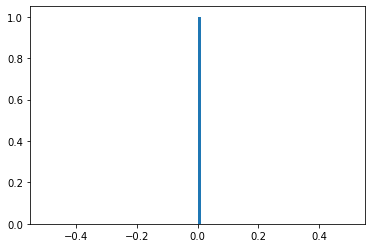

In [301]:
MC = MonteCarlo()
plt.hist(MC.simulate(10000,5/12),bins=100)